# AffectiveLens: Research & Automated Error Analysis

This notebook contains a deep, automated error analysis to elevate the AffectiveLens project into a research paper. It is a standalone script that automatically downloads all necessary artifacts, identifies the champion model's errors, and performs a rule-based classification of those errors to provide quantitative insights for research.

In [ ]:
import sys
!{sys.executable} -m pip install "scikit-learn==1.3.2" pandas numpy matplotlib seaborn joblib huggingface_hub transformers datasets

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from huggingface_hub import HfApi, hf_hub_download, snapshot_download
from datasets import load_dataset, Dataset
import joblib
import os
from sklearn.model_selection import train_test_split

MODEL_REPO_ID = "psyrishi/affectivelens-emotion-models"
DATASET_REPO_ID = "psyrishi/MoodPulse"
LOCAL_DATA_DIR = "./data/"
BROAD_EMOTION_CATEGORIES = ['negative', 'neutral', 'positive']

print(f"--- Loading all models from '{MODEL_REPO_ID}' ---")
api = HfApi()
model_files = [f for f in api.list_repo_files(MODEL_REPO_ID) if f.endswith(".pkl")]
loaded_models = {}
for filename in model_files:
    model_path = hf_hub_download(repo_id=MODEL_REPO_ID, filename=filename)
    loaded_models[filename] = joblib.load(model_path)
print(f"\nSuccessfully loaded {len(loaded_models)} models.")

print(f"\n--- Downloading dataset '{DATASET_REPO_ID}' to '{LOCAL_DATA_DIR}' ---")
snapshot_download(repo_id=DATASET_REPO_ID, repo_type='dataset', local_dir=LOCAL_DATA_DIR)
print("Dataset download complete.")

test_embeddings_path = os.path.join(LOCAL_DATA_DIR, './embeddings/MentalTest')
raw_data_path = os.path.join(LOCAL_DATA_DIR, './full_dataset')

print(f"\nLoading test set embeddings from local path...")
test_embeddings_dataset = Dataset.load_from_disk(test_embeddings_path)
X_test = np.array(test_embeddings_dataset['cls_embedding'], dtype='float32')
Y_test_original_2D = np.array(test_embeddings_dataset['labels'], dtype=int)

print(f"\nLoading original text data from local path...")
file_paths = [os.path.join(raw_data_path, f"goemotions_{i}.csv") for i in [1, 2, 3]]
full_raw_df = pd.concat([pd.read_csv(f) for f in file_paths], ignore_index=True)
full_raw_df.drop_duplicates(inplace=True)

_, test_df_for_text = train_test_split(full_raw_df, test_size=0.20, random_state=42)
original_test_texts = test_df_for_text['text'].tolist()

assert len(original_test_texts) == len(Y_test_original_2D), f"FATAL: Mismatch in data sizes. Texts: {len(original_test_texts)}, Labels: {len(Y_test_original_2D)}"

print("\nAll necessary artifacts have been loaded and verified.")

--- Loading all models from 'psyrishi/affectivelens-emotion-models' ---

Successfully loaded 6 models.

--- Downloading dataset 'psyrishi/MoodPulse' to './data/' ---


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

Dataset download complete.

Loading test set embeddings from local path...

Loading original text data from local path...

All necessary artifacts have been loaded and verified.


In [6]:
goemotions_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion",
    "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment",
    "excitement", "fear", "gratitude", "grief", "joy", "love", "nervousness", "optimism",
    "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"
]

positive_indices = {i for i, label in enumerate(goemotions_labels) if label in ["admiration", "amusement", "approval", "caring", "curiosity", "desire", "excitement", "gratitude", "joy", "love", "optimism", "pride", "relief", "surprise"]}
negative_indices = {i for i, label in enumerate(goemotions_labels) if label in ["anger", "annoyance", "disappointment", "disapproval", "disgust", "embarrassment", "fear", "grief", "nervousness", "remorse", "sadness"]}

def transform_to_broad_category_single(original_labels):
    broad_labels = np.full(original_labels.shape[0], 1, dtype=int)
    has_positive = original_labels[:, list(positive_indices)].any(axis=1)
    has_negative = original_labels[:, list(negative_indices)].any(axis=1)
    broad_labels[has_positive] = 2
    broad_labels[has_negative] = 0
    return broad_labels

Y_test = transform_to_broad_category_single(Y_test_original_2D)
print("True labels prepared for analysis.")

True labels prepared for analysis.



--- Generating Predictions and Confusion Matrix for Champion Model ---
Champion model identified as: LightGBM_MicroF1_0.6240.pkl


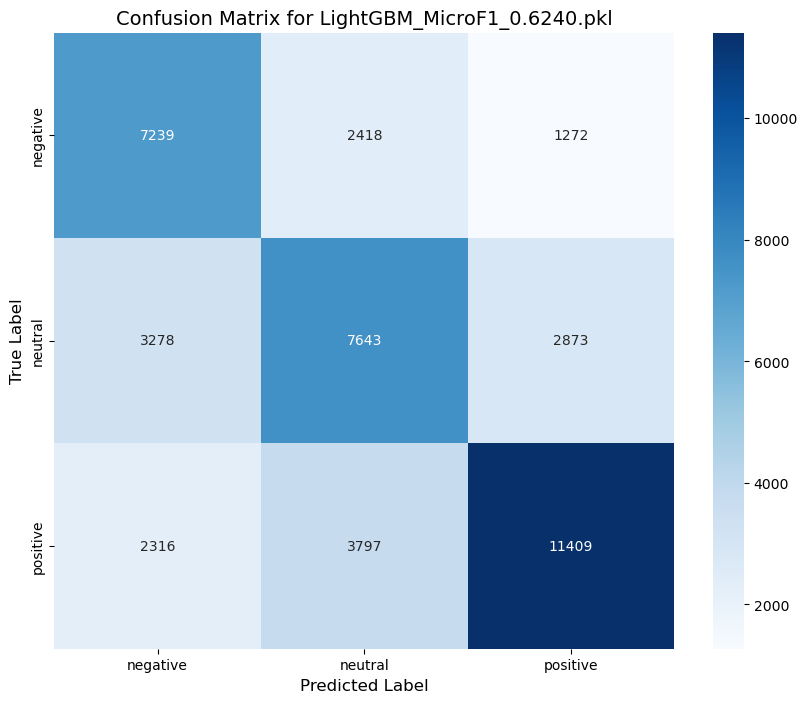

In [7]:
print("\n--- Generating Predictions and Confusion Matrix for Champion Model ---")

champion_model_name = max(loaded_models.keys(), key=lambda name: float(name.split('_MicroF1_')[-1].replace('.pkl', '')))
champion_model = loaded_models[champion_model_name]
print(f"Champion model identified as: {champion_model_name}")

Y_test_pred = champion_model.predict(X_test)

cm = confusion_matrix(Y_test, Y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=BROAD_EMOTION_CATEGORIES, yticklabels=BROAD_EMOTION_CATEGORIES)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix for {champion_model_name}', fontsize=14)
plt.show()

In [8]:
print("\n--- Creating DataFrame of Misclassified Examples ---")

error_mask = Y_test != Y_test_pred
error_texts = np.array(original_test_texts)[error_mask]
error_true_labels = Y_test[error_mask]
error_pred_labels = Y_test_pred[error_mask]
error_original_28d_labels = Y_test_original_2D[error_mask]

error_true_names = [BROAD_EMOTION_CATEGORIES[l] for l in error_true_labels]
error_pred_names = [BROAD_EMOTION_CATEGORIES[l] for l in error_pred_labels]

error_df = pd.DataFrame({
    'text': error_texts,
    'true_emotion': error_true_names,
    'predicted_emotion': error_pred_names,
    'original_28d_labels': list(error_original_28d_labels)
})

print(f"Found {len(error_df)} misclassified examples.")


--- Creating DataFrame of Misclassified Examples ---
Found 15954 misclassified examples.


### Automated First-Pass Error Tagging

This section performs an automated, rule-based classification of the errors. While not a substitute for human analysis, it provides a powerful quantitative starting point for a research paper by identifying common patterns in the model's failures.

In [9]:
print("\n--- Performing Automated Error Tagging ---")

def tag_error(row):
    text = row['text'].lower()
    original_labels = row['original_28d_labels']
    
    # Rule 1: Mixed Emotion (most reliable rule)
    # Check if the original 28-dim label had both positive and negative signals
    has_positive_signal = any(original_labels[i] for i in positive_indices)
    has_negative_signal = any(original_labels[i] for i in negative_indices)
    if has_positive_signal and has_negative_signal:
        return "Mixed Emotion"
    
    # Rule 2: Complex Negation
    negation_words = ['not', 'never', 'no ', 'isnt', 'arent', 'wasnt', 'werent', 'dont', 'doesnt', 'didnt']
    if any(word in text for word in negation_words):
        return "Complex Negation"
        
    # Rule 3: Potential Sarcasm (heuristic)
    # Looks for positive words followed by a contrastive conjunction
    sarcastic_pattern = False
    positive_words = ['great', 'love', 'amazing', 'perfect', 'wonderful']
    contrast_words = ['but', 'however', 'still', 'though']
    if any(p in text for p in positive_words) and any(c in text for c in contrast_words):
        sarcastic_pattern = True
    if 'yeah right' in text or 'sure' in text.split() or sarcastic_pattern:
        return "Potential Sarcasm"
        
    # Rule 4: Ambiguity (heuristic for short, non-committal text)
    if len(text.split()) < 5:
        return "Potential Ambiguity (Short Text)"
        
    return "Other"

error_df['predicted_error_type'] = error_df.apply(tag_error, axis=1)

print("Automated tagging complete. Displaying a sample of tagged errors:")
error_df.sample(15, random_state=42)


--- Performing Automated Error Tagging ---
Automated tagging complete. Displaying a sample of tagged errors:


,text,true_emotion,predicted_emotion,original_28d_labels,predicted_error_type
1328,We still have this?!!!!!!!! What?!,positive,neutral,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",Other
9696,Sounds like people who are making a career out...,neutral,negative,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Other
5309,Nothing good can come from knowing. Just let i...,negative,positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",Mixed Emotion
13896,"I can live with the bad textures, I just want ...",negative,neutral,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",Other
10104,"I don’t squirm at much, but getting the notifi...",negative,neutral,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",Complex Negation
9995,I feel like people kind of just... forgot abou...,negative,positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",Mixed Emotion
3859,Yeah it isn't the same singer. 'Don't hug me I...,negative,neutral,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",Other
12156,Maybe you just enjoy the process of digging? D...,positive,neutral,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Other
12413,He was going for a new record for fastest to t...,positive,neutral,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Other
1870,My same thoughts! Post this there and see what...,neutral,positive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Other



--- Quantitative Summary of Predicted Error Types ---
predicted_error_type
Other                               10879
Complex Negation                     3027
Potential Ambiguity (Short Text)     1215
Mixed Emotion                         632
Potential Sarcasm                     201
Name: count, dtype: int64


C:\Users\admin\AppData\Local\Temp\ipykernel_2344\3323566198.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_counts.index, y=error_counts.values, palette='viridis')


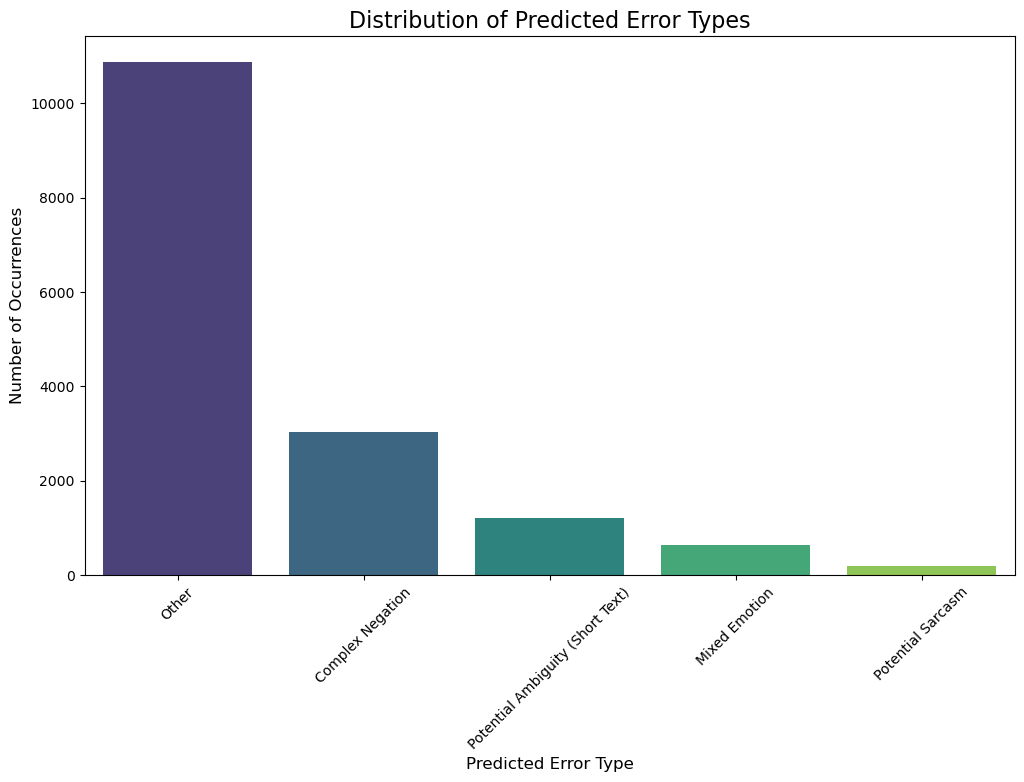

In [10]:
print("\n--- Quantitative Summary of Predicted Error Types ---")

error_counts = error_df['predicted_error_type'].value_counts()
print(error_counts)

plt.figure(figsize=(12, 7))
sns.barplot(x=error_counts.index, y=error_counts.values, palette='viridis')
plt.title('Distribution of Predicted Error Types', fontsize=16)
plt.xlabel('Predicted Error Type', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [11]:
print("\n--- Exporting Full Error Analysis for Manual Review ---")
error_df.to_csv('automated_error_analysis.csv', index=False)
print("Tagged misclassified examples have been saved to 'automated_error_analysis.csv'.")


--- Exporting Full Error Analysis for Manual Review ---
Tagged misclassified examples have been saved to 'automated_error_analysis.csv'.
